In [1]:
#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']


#######################
#       imports       #
#######################
import pandas as pd
import seaborn as sns
# import sklearn

sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


<h1 class="title"> Support Vector Machines </h1>


# Key Concepts

- Parametric Models
- Model Linearity

## Parametric models

<u>**Parametric Models**</u> learn a finite (and typically fixed) number of parameters.

- Example: <u>logistic regression</u> uses the prediction function $f(\mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x})$
    - The weight matrix $\mathbf{w}$ is fixed by the number of features used.


- The good
    - Fewer parameters to store in memory
    - Useful when a strong bias is merited
    - More interpretable
- The bad
    - Limited in what can in theory be learned. 

<u>**Nonparametric Models**</u> have no fixed set of parameters to learn. Often nonparametric models learn a potentially infinite set of parameters.

- Example: <u>K Nearest Neighbors</u> 
    - KNN memorizes all observed examples. While KNN has no fixed parameters like logistic regression, the examples memorized by KNN could be considered parameters.


- The good
    - Quite flexible.
    - Often come with guarantees. With enough examples and a limit on noise, KNN is guaranteed to learn most classification functions. 
- The bad
    - (Potentially) infinite parameters means (potentially) infinite memory storage.

## Model Linearity

- See [Model Linearity lesson](../model-linearity/Model_Linearity.ipynb)

- Linear functions are made up of two operations: matrix multiplication and addition.
    - Linear Models are made up of only linear operations are unable to learn non-linear functions.

<img class="big" src=../model-linearity/images/lin_models.png>


<img class="big" src=../model-linearity/images/nonlin_models.png>

## SVMs

Support Vector Machines are a hybrid model that achieves nice trade-offs in a few ways:

- SVMs are *non-parametric*.
    - **However**: SVMs are designed to only remember the examples they need.
- SVMs are built on the same linear equation we've seen elsewhere: $f(\mathbf{x}) = \mathbf{w}^\top\mathbf{x} + b$.
    - **However**: SVMs are able to learn non-linear functions by using the "kernel trick" (more on this later!).

# How do SVMs work?

## 1) Example-based linear function

<small>Note: below, we'll distinguish between $\mathbf{x}_{\text{train}}$, our training examples, and $\mathbf{x}_{\text{test}}$, our testing examples.</small>

The first insight of SVMs is to write our traditional linear equation in terms of a dot product between examples. 

Our original linear equation now looks like $f(\mathbf{x}_{\text{test}}) = \mathbf{w}^\top\mathbf{x}_{\text{test}} + b$. A model learns a weight matrix $\mathbf{w}$ and a bias $b$ from the training data and then applies those to test data.

SVMs re-write this using the inner product between examples instead of a weight matrix:

$$\mathbf{w}^\top\mathbf{x}_{\text{test}} + b = b + \sum^{m}_{i=1}\alpha_i\mathbf{x}_{\text{test}}^\top \mathbf{x}_{\text{train}}[i,:]$$

Here, we're learning a set of coefficients $\mathbf{\alpha} = [\alpha_0, \alpha_1, \dots \alpha_n]$, one for each of the $n$ training examples.

Note: the details of how this new equation are arrived at are going to be skipped over for now. If you wish to explore more details on your own, this is called the ["dual problem"](https://en.wikipedia.org/wiki/Support_vector_machine#Dual).

## Demo


Let's prove that this example-based function still works. First, we'll re-do an exercise from the Model Linearity lesson, then we'll build a similar exercise for the example-based formula.  

First, we generate a small blob dataset.

Text(0.5, 1.0, 'Two random Gaussian clusters')

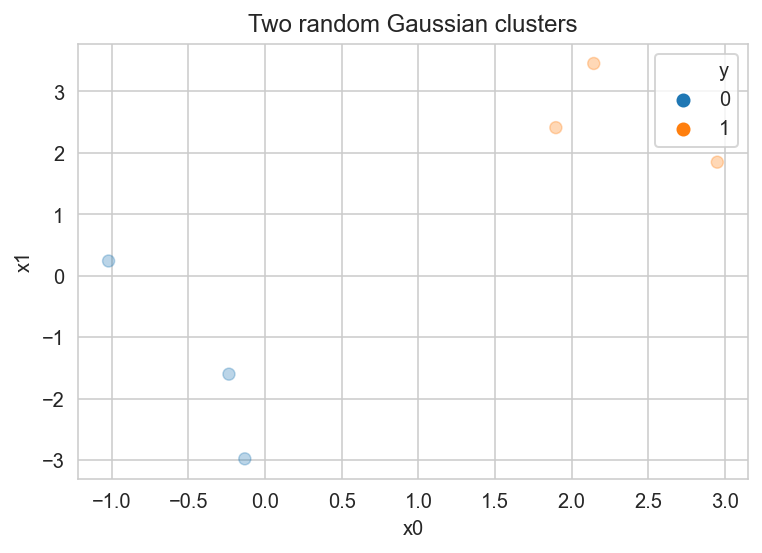

In [2]:
from sklearn import datasets

x, y = datasets.make_blobs(
    n_samples=6, n_features=2, centers=[[-2, -2], [2, 2]], random_state=0)

blob_df = pd.DataFrame({"x0": x[:,0], "x1": x[:,1], "y":y})

sns.scatterplot(x="x0", y="x1", hue="y", data=blob_df, alpha=.3, edgecolor=None)
title("Two random Gaussian clusters")

In [3]:
from sklearn import metrics

pal = dict(enumerate(sns.color_palette("husl", 4)))


def plot_decision_boundary(pred_func,
                           x,
                           y,
                           ax=None,
                           points=1e3,
                           pal=pal,
                           margin_func=None):

    if ax is None:
        fig, ax = subplots()

    y_pred = pred_func(x)
    score = metrics.accuracy_score(y_pred.flatten(), y.flatten())

    sns.scatterplot(
        x=x[:, 0],
        y=x[:, 1],
        hue=y,
        alpha=.5,
        edgecolor=None,
        palette=pal,
        ax=ax)

    side_pts = int(sqrt(points))

    x0_min, x0_max = ax.get_xlim()
    x1_min, x1_max = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(x0_min, x0_max, num=side_pts),
        np.linspace(x1_min, x1_max, num=side_pts))

    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.text(
        (x0_min + x0_max) / 2,
        x1_min + (x1_max - x1_min) * .1,
        f"acc: {score:.1%}",
        bbox=dict(boxstyle="round", fc="white", ec="black"))

    ax.contourf(xx, yy, Z, alpha=0.2, colors=list(pal.values()), zorder=-1)

    if not (margin_func is None):
        Z = margin_func(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

        # plot decision boundary and margins
        ax.contour(
            xx,
            yy,
            Z,
            colors='k',
            levels=[-1, 1],
            alpha=0.5,
            linestyles=['--', '--'],
            zorder=0)

Below is a function that calculates a linear classifier using a weight matrix

In [4]:
def lin_weight_func(x_test, w, b):
    f_out = w.T.dot(x_test.T) + b
    return (f_out > 0).astype(int).flatten()

In [5]:
def weight_widget(w0, w1, b):
    w = array([[w0], [w1]])

    plot_decision_boundary(
        lambda x: lin_weight_func(x, w, b),
        x=blob_df[["x0", "x1"]].values,
        y=blob_df["y"].values,
        points=1e4)
    plt.title(f"Accuracy for $f(x) = [{w0}, {w1}]^\\top \\mathbf{{x}}$ + {b}")
    return (w0, w1, b)

## Exercise: 

We will use the weight-based function to solve a small problem with an SVM. The function has been incorporated into a widget that appears below.

You will need to find values for $\mathbf{w}$ and $b$ that give the best classifier.

$$\underbrace{\mathbf{w}^\top\mathbf{x}_\text{test} + b}_\text{Weight-based function}
    = b + \sum^{m}_{i=1}\alpha_i\mathbf{x}_{\text{test}}^\top \mathbf{x}_{\text{train}}[i,:]$$

In [6]:
from ipywidgets import interact, interactive, HBox, VBox, interactive_output

from IPython.display import display

In [7]:
interact(weight_widget,w0=(-10,10,1),w1=(-10,10,1),b=(-10,10,1));

interactive(children=(IntSlider(value=0, description='w0', max=10, min=-10), IntSlider(value=0, description='w…

Now let's use the example-based method.

This time, the function below executes an equivalent linear function using a weighted sum of dot products from training examples instead of a weight matrix.

In [8]:
def lin_ex_func(x_test, x_train, a, b):
    n_test = x_test.shape[0]
    sum_out = np.zeros((n_test, 1))
    for i in range(x_train.shape[0]):
        x_i = x_train[[i],:]
        sum_out += a[i]*(x_test.dot(x_i.T))
    f_out = sum_out + b
    
    return (f_out > 0).astype(int).flatten()

In [9]:
def ex_widget(a0, a1, a2, a3, a4, a5, b):
    a = array([a0, a1, a2, a3, a4, a5])

    plot_decision_boundary(
        lambda x_test: lin_ex_func(x_test, x, a, b),
        x=blob_df[["x0", "x1"]].values,
        y=blob_df["y"].values,
        points=1e4)
    for i in range(6):
        plt.text(blob_df.loc[i,"x0"], blob_df.loc[i,"x1"], str(i))
    plt.title(f"Accuracy for a = [{a}], b = {b}")
    return (a0, a1, a2, a3, a4, a5, b)

In [10]:
from ipywidgets import widgets
a_widgets = {}
for i in range(6):
    a_widgets[f"a{i}"]= widgets.FloatText(
        value=0.0,
        description=f"a{i}",
        disabled=False
    )

## Exercise:

Now, we'll solve the same problem with an SVM using the equivalent example-based function. The function has been incorporated into a widget that appears below.

You will need to find values for $\mathbf{a}$ and $b$ that give the best classifier.

$$\mathbf{w}^\top\mathbf{x}_\text{test} + b
    = \underbrace{
        b + \sum^{m}_{i=1}\alpha_i\mathbf{x}_{\text{test}}^\top \mathbf{x}_{\text{train}}[i,:]
       }_\text{Example-based function}
$$


Hints

- The index of each example corresponds to an $a_i$. These have been labeled for you.
- Start with all zeros.
    - What is the effect of turning one example from $0\rightarrow1$?
    - What is the effect of turning one example from $0\rightarrow-1$?
    - What is the effect of adjusting $b$?

In [11]:
from ipywidgets import interact
interact(ex_widget,b=widgets.FloatText(
        value=0.0,
        description=f"b",
        disabled=False
    ), **a_widgets);

interactive(children=(FloatText(value=0.0, description='a0'), FloatText(value=0.0, description='a1'), FloatTex…

# Discussion

- Go back to the example-based widget.
- Compare two solutions that both get 100% accuracy. Do you see any advantages to either solution?  
    - Solution 1: $a=[1, -1, 1, 1, -1, -1]$
    - Solution 2: $a=[0, 0, 0, 1, -1, 0]$  
    
    
- If we keep $b=0$ our model is perfectly accurate. We could actually use several different values for $b$ and get the same score. How should decide between them?

[](https://www.dropbox.com/s/lsbse60wi31lhl0/2018-12-06_11-59-43.png?raw=1)

# sklearn version

Now, let's confirm that the model in `sklearn` works the same way.

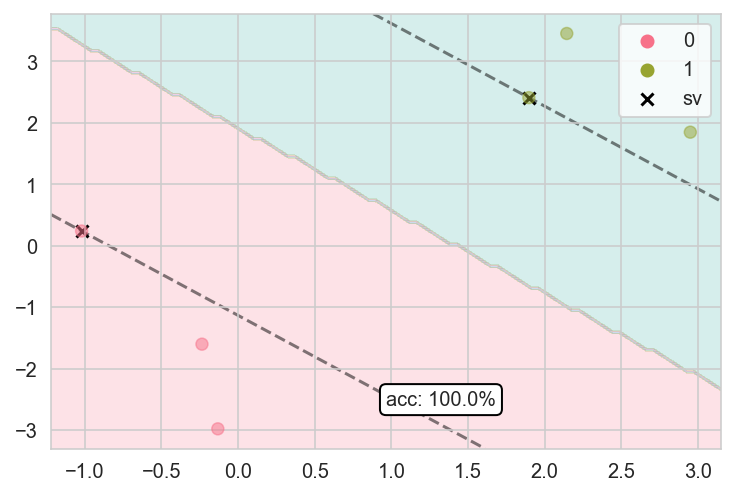

In [12]:
from sklearn import svm

svm_model = svm.SVC(kernel="linear")
svm_model.fit(x, y)

plot_decision_boundary(
    svm_model.predict,
    x=blob_df[["x0", "x1"]].values,
    y=blob_df["y"].values,
    points=1e4, margin_func=svm_model.decision_function)

sv_scatter = plt.scatter(
    svm_model.support_vectors_[:, 0],
    svm_model.support_vectors_[:, 1],
    marker="x",
    label="sv",
    c="black",
    zorder=-1)

plt.legend()

In [13]:
print("support vectors: ", svm_model.support_vectors_)
print("coefficients: ", svm_model.dual_coef_)
print("intercept: ", svm_model.intercept_)

support vectors:  [[-1.02126202  0.2408932 ]
 [ 1.89678115  2.4105985 ]]
coefficients:  [[-0.15125622  0.15125622]]
intercept:  [-0.62830004]


Here we see:
- `svm_model.support_vectors_` contains the support vectors. These are the same ones we found in our own solution above. 
- `svm_model.dual_coef_` is what we called $\mathbf{a}$ and `svm_model.intercept_` is what we called $b$. These are different in scale, but otherwise quite similar to what we found above.

# Need for Improvement

So far, SVMs sound great, but we'll run into a few problems when we start to apply the model to real data:

- A **maximum margin** classifier sounds great when data is clearly separable, but what happens when we have noisy data that can't be cleanly divided?
- We have not yet discussed how SVMs can be used to learn nonlinear functions. 

## Improvement 1: Soft Margin

Today, all major SVM implementations use what is called a **soft margin**. Under this approach SVMs balance two priorities:

1. finding the boundary with the largest margin between classes and
2. finding the boundary with the smallest training error. 

Soft margin works by modifying the loss function to include a term that penalizes classification error. For this lesson, we won't be going into the details of how this loss function is arrived at, but it is reproduced below:

$$
C\underbrace{
    \left[\frac 1 n \sum_{i=1}^n \max\left(0, 1 - y_i(\mathbf{w}^\top \mathbf{x}_i - b)\right) \right]
}_\text{error penalty}
    + 
\underbrace{
    \lVert \mathbf{w} \rVert^2
}_\text{margin penalty}
$$

The "margin penalty" is what the SVMs we've discussed so far are optimizing. This term roughly corresponds to generalization error: the larger the margin, the better our model will tend to generalize.

The "error penalty" term is zero if all examples are correctly classified and increases with the number and severity of errors.

## Soft Margin Demo

Here we'll pull in the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) to demo the soft-margin SVM on data that is not linearly separable.

In [14]:
# pulling in our iris dataset for a quick viz
iris_data = datasets.load_iris()
iris_df = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris_df["species"] = iris_data.target

# only use the last two classes
iris_df = iris_df.query("species > 0")
iris_df.species = iris_df.species - 1

Here's the two features we'll look at

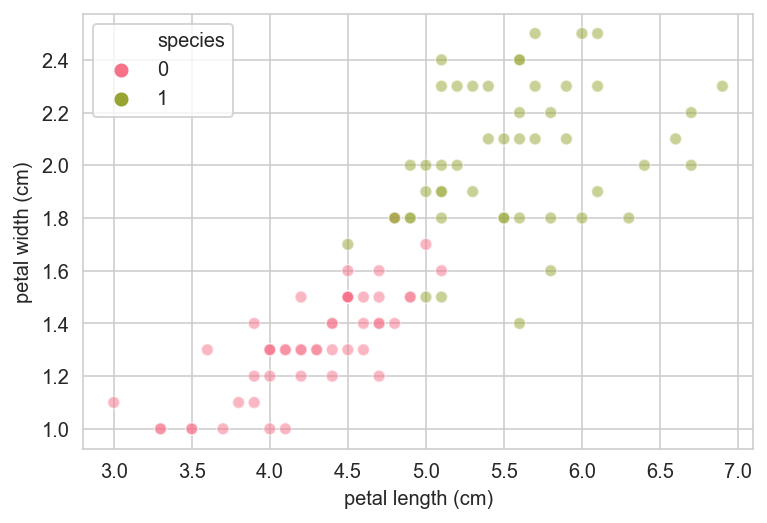

In [15]:
sns.scatterplot(
    x="petal length (cm)",
    y="petal width (cm)",
    hue="species",
    alpha=.5, data=iris_df, palette=pal);

In [16]:
x = iris_df[["petal length (cm)", "petal width (cm)"]].values
y = iris_df.species.values


def c_widget(c):
    svm_model = svm.SVC(C=c, kernel="linear")

    svm_model.fit(x, y)

    plot_decision_boundary(svm_model.predict, x=x, y=y, points=1e4, margin_func=svm_model.decision_function)

    sv_scatter = plt.scatter(
        svm_model.support_vectors_[:, 0],
        svm_model.support_vectors_[:, 1],
        marker="x",
        c="black",
        zorder=-1, label="sv")

    ax = plt.gca()
    h,l = ax.get_legend_handles_labels()
    plt.legend(h, ["Virginica", "Versicolor", "Support Vectors"])
    
    plt.title(f"Soft margin SVM with C = {c:g}")
    plt.xlabel("petal length")
    plt.ylabel("petal width")
    
    return c

## Discussion:

Adjust the $C$ parameter. Describe how the model and its decision boundary are changing.

In [17]:
interact(
    c_widget,
    c=widgets.FloatLogSlider(
        value=10,
        base=10,
        min=-2,  # max exponent of base
        max=8,  # min exponent of base
        step=0.5,  # exponent step
        description='C',
        continuous_update=False))

interactive(children=(FloatLogSlider(value=10.0, continuous_update=False, description='C', max=8.0, min=-2.0, …

<function __main__.c_widget(c)>

# Improvement 2: The kernel trick

## What's a kernel? 🤷‍

A **kernel** maps a function from its original domain to another domain where a problem might be easier to solve.

Some interesting domains:
- *Polynomial* this is similar to using the `PolynomialFeatures` tool in preprocessing. It allows the model to make predictions based on higher order polynomial transformations of our input features.
- *RBF-Radial Basis Function* this is similar to selecting examples as prototypes of a class. The radial basis function decreases as a test point gets farther away from this prototype in any direction (thus "radial"). 

**How does this work?**

Recall that earlier we rewrote the linear function to use dot products between examples instead of a weight matrix:

$$f(\mathbf{x}_\text{test})= b + \sum^{m}_{i=1}\alpha_i\mathbf{x}_{\text{test}}^\top \mathbf{x}_{\text{train}}[i,:]$$

A kernel allows us to make use of a different domain without transforming the individual examples first. If we have a transformation on $\mathbf{x}$, $\phi(\mathbf{x})$, the kernel function *implicitly* finds the dot product between transformed inputs—that is, **without actually performing the transformation explicitly**. 

$$K(\mathbf{x}, \mathbf{x}') = \phi(\mathbf{x})^\top\phi(\mathbf{x}')$$

<small>While there are certainly more details, that is as deep as we need to go for now.</small>

**Key Points**

- Using a kernel allows us to use different domains (including nonlinear ones) efficiently.
- The kernel trick works by *implicitly* finding the dot product between transformed inputs.
    - Allows us to use a linear classifier to efficiently leverage domains with large (or even infinite in the case of RBF) feature spaces.
    - Allows SVMs to learn nonlinear decision boundaries. 🎉

Let's see it in action

In [18]:
# dataset generation from https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py

n_samples = 500
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, centers=2, random_state=0)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, centers=2, random_state=0)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples,
    centers=2,
    cluster_std=[.7, 2.5],
    random_state=random_state)

datasets_str = ["noisy_circles", "noisy_moons", "blobs", "aniso", "varied"]
kernels = ['linear', 'poly', 'rbf']

In [19]:
def kernel_widget(d_name, k_name, degree=3, c=1.0, gamma=.5):

    x, y = eval(d_name)

    svm_model = svm.SVC(
        kernel=k_name, gamma=gamma, degree=degree, C=c, cache_size=1000, max_iter=1000)
    svm_model.fit(x, y)

    plot_decision_boundary(
        svm_model.predict,
        x,
        y,
        points=1e4,
        margin_func=svm_model.decision_function)

    sv_scatter = plt.scatter(
        svm_model.support_vectors_[:, 0],
        svm_model.support_vectors_[:, 1],
        marker="x",
        c="black",
        zorder=-1,
        label="sv")
    
    n_sv = svm_model.support_vectors_.shape[0]
    
    plt.title(f"{k_name}-svm on {d_name}. d={degree}, c={c:g}, gamma={gamma:g}. {n_sv} support vectors" )

    plt.legend()

In [20]:
d_name_w = widgets.RadioButtons(
    options=datasets_str, description='Dataset:', disabled=False)
k_name_w = widgets.RadioButtons(
    options=kernels, description='Kernel:', disabled=False)
degree_w = widgets.IntSlider(
    value=3,
    min=0,
    max=10,
    step=1,
    description='Degree: ',
    continuous_update=False)
c_w = widgets.FloatLogSlider(
    value=1,
    base=10,
    min=-2,  # max exponent of base
    max=6,  # min exponent of base
    step=0.5,  # exponent step
    description='C: ',
    continuous_update=False)
gamma_w = widgets.FloatLogSlider(
    value=.5,
    base=2,
    min=-5,  # max exponent of base
    max=6,  # min exponent of base
    step=0.5,  # exponent step
    description='Gamma: ',
    continuous_update=False)
ui = HBox([
    VBox([d_name_w]),
    VBox([k_name_w]),
    VBox([degree_w, c_w, gamma_w])
])

In [21]:
from sklearn import exceptions
import warnings

warnings.filterwarnings("ignore", category=exceptions.ConvergenceWarning)

NameError: name 'warnings' is not defined

# Discussion

Test out the different kernels and datasets. Get a feel for what each parameter does. 

Describe in your own words
- What sorts of functions do the poly and rbf kernels tend to learn?
- What does the `gamma` parameter do?

In [ ]:
out = interactive_output(kernel_widget, {"d_name":d_name_w,
                                   "k_name": k_name_w, 
                                   "degree":degree_w, 
                                   "c": c_w, 
                                   "gamma":gamma_w})
display(ui, out)

# Discussion Answers

- What sorts of functions do the poly and rbf kernels tend to learn?




- What sorts of functions do the poly and rbf kernels tend to learn?






- What does the `gamma` parameter do?


# Exercise: Tuning can reduce the number of support vectors

Let's revisit the previous widget. This time, see if you can determine how to tune the model to reduce the number of support vectors.

# Solution:

For all kernels: 
  - Increasing $C$ tends to reduce the number of support vectors.
  - Reducing training error (by finding a kernel or parameters that better capture the data) tends to reduce the number of support vectors.
    
For poly and RBF:
  - Increasing `gamma` tends to reduce the number of support vectors.